### Step 1: Load the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from google.cloud import bigquery
from google.cloud import bigquery_storage
import datetime as dt
from datetime import date, datetime, timedelta
from math import ceil
import warnings
warnings.filterwarnings(action = 'ignore')

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


### Step 2.1: Enter some input parameters

In [2]:
alpha_lvl = 0.05
start_date = dt.date(2022, 8, 31)
end_date = dt.date(2022, 9, 27)
test_period = (end_date - start_date).days + 1
# Define the list of KPIs
col_list = [
    'actual_df_paid_by_customer', 'gfv_local', 'gmv_local', 'commission_local', 'joker_vendor_fee_local', # Customer KPIs (1)
    'sof_local', 'service_fee_local', 'revenue_local', 'delivery_costs_local', 'gross_profit_local', # Customer KPIs (2)
    'dps_mean_delay', 'delivery_distance_m', 'actual_DT' # Logistics KPIs
]
sb_interval_dict = {'12_hr_sb': 12, '6_hr_sb': 6, '4_hr_sb': 4, '2_hr_sb': 2, '1_hr_sb': 1, '0.5_hr_sb': 0.5, '0.25_hr_sb': 0.25} # Exclude the 8-hour window size

### Step 2.2: Run the queries to pull the data

In [3]:
client = bigquery.Client(project = 'logistics-data-staging-flat')
bq_storage_client = bigquery_storage.BigQueryReadClient()

df = client.query("""SELECT * FROM `dh-logistics-product-ops.pricing.ab_test_individual_orders_augmented_additional_deep_dives`""")\
    .result()\
    .to_dataframe(bqstorage_client = bq_storage_client)

### Step 3: Do the results of these simulations hold for any random choice of zones where we did not impose tight controls over price changes, but know that they had no tests (i.e., simple historical data)?

In [4]:
# Obtain a list of zones whose order count >= 10000
df_orders_by_zone = df[['entity_id', 'zone_name_customer']].value_counts().to_frame(name = 'count_orders').sort_values(by = ['entity_id', 'count_orders'], ascending = [False, False])
df_orders_by_zone = df_orders_by_zone[df_orders_by_zone['count_orders'] >= 10000]
df_eda_3 = df[df['zone_name_customer'].isin(df_orders_by_zone.index.get_level_values('zone_name_customer'))]

#### Step 3.1: Change the data types of columns in the dataset

In [5]:
# Define the start of the data frame where the data types of columns need to be changed 
col_start = np.where(df_eda_3.columns == 'exchange_rate')[0][0]

# Change data types --> df[df.cols = specific cols].apply(pd.to_numeric)
df_eda_3[df_eda_3.columns[col_start:]] = df_eda_3[df_eda_3.columns[col_start:]].apply(pd.to_numeric, errors = 'ignore')

#### Step 3.2: Define a function that changes the font color based on the p-value

In [6]:
# Define a function that changes the font color based on the p-value
def color_sig_green(val):
    """
    Takes a scalar and returns a string with the css property 'color: green' for statistically significant values, red otherwise
    """
    if pd.isna(val) == False:
        if val <= alpha_lvl:
            color = 'lime'
        else:
            color = 'red'
    else:
        color = 'white'
    return 'color: %s' % color

#### Step 3.3: Define a function that assigns random control and variation labels to orders based on a chosen window size

In [7]:
def hr_interval_func_random(sb_interval):
    bins = int(24 / sb_interval) # The number of bins by which we will divide the range from 0 to 24. A 2-hour switchback interval will have 12 bin --> [0, 2), [2, 4), [4, 6), ... [22, 24)
    if sb_interval >= 1:
        end_of_range = 25
    elif sb_interval == 0.5:
        end_of_range = 24.5
    elif sb_interval == 0.25:
        end_of_range = 24.25
    df_mapping = pd.DataFrame(data = {
            'hr_interval': list(pd.cut(np.arange(0, end_of_range, sb_interval), bins = bins, right = False)) # The bins should be closed from the left
        }
    )

    # Drop duplicates
    df_mapping.drop_duplicates(inplace = True)

    unique_intervals = df_mapping['hr_interval'].unique()
    on_off_list = ['On', 'Off'] * ceil(len(unique_intervals) / 2) # Create the full list that the rng.choice would choose from

    rng = np.random.default_rng()
    df_mapping['treatment_status_by_time'] = rng.choice(on_off_list, replace = False, axis = 0, size = len(df_mapping))
    return df_mapping

def hr_interval_date_func_random(test_start, test_length, sb_interval):
    m = []
    date_iter = test_start # Start date of the test in datetime format
    for i in range(0, test_length): # The length of a test in days
        y = hr_interval_func_random(sb_interval) # The switchback window size
        y['sim_run'] = i + 1
        y['order_created_date_local'] = date_iter
        date_iter = date_iter + timedelta(days = 1)
        m.append(y)

    m = pd.concat(m)
    m.reset_index(inplace = True, drop = True)
    return m

def day_interval_date_func_random(test_start, test_length): # np.arange has hard-coded 25 and 24 because this function is intended for randomizing the daily assignment of treatment
    rng = np.random.default_rng()
    on_off_list = ['On', 'Off'] * ceil(test_length / 2) # Create the full list that the rng.choice would choose from
    df_mapping = pd.DataFrame(
        data = {
            'hr_interval': list(pd.cut(np.arange(0, 25, 24), bins = 1, right = False))[0], # The bins should be closed from the left
            'sim_run': np.arange(1, test_length + 1, 1),
            'order_created_date_local': pd.date_range(start = start_date, periods = 28).date.tolist(),
        }
    )
    df_mapping['treatment_status_by_time'] = rng.choice(on_off_list, replace = False, axis = 0, size = test_length)
    return df_mapping

#### Step 3.5: Create a function that returns the right hr_interval from df_mapping for any given number

In [8]:
def check_right_interval(num, col):
    for i in col:
        if num in i:
            return i
        else:
            pass

#### Step 3.6: Create a function that calculates the p-values for a given zone

In [9]:
def sig_calc_time_region_units_func(df, entity_id, zone_name, sb_interval_hr): # sb_groupby_col could be 'on_or_off_day' or 'treatment_status_by_time' 
    df['entity_zone_name_customer'] = df['entity_id'] + ' | ' + df['zone_name_customer']
    df_t_test = df[df['entity_zone_name_customer'] == entity_id + ' | ' + zone_name]
    
    # Create a new column with the located created_date of the order 
    df_t_test['order_created_date_local'] = df_t_test['order_placed_at_local'].dt.date

    # Filter for the data between test_start and test_end
    df_t_test = df_t_test[df_t_test['order_created_date_local'].between(start_date, end_date)]

    # Create the mapping data frame that has the 'On'/'Off' flag for each time interval
    df_mapping = hr_interval_date_func_random(test_start = start_date, test_length = test_period, sb_interval = sb_interval_hr)

    # Get the hour from the "order_placed_at_local" column
    df_t_test['hr_of_day'] = round(df_t_test['order_placed_at_local'].dt.hour + df_t_test['order_placed_at_local'].dt.minute / 60 + df_t_test['order_placed_at_local'].dt.second / 3600, 2)
    
    # Get the right interval using the "check_right_interval" function
    df_t_test['hr_interval'] = df_t_test.apply(lambda x: check_right_interval(x['hr_of_day'], df_mapping['hr_interval'].unique()), axis = 1)

    # Map the "hr_interval" to the correct treatment_status
    df_t_test = pd.merge(left = df_t_test, right = df_mapping, how = 'left', on = ['hr_interval', 'order_created_date_local'])

    # Calculate the mean values per created_date_local date (time-region unit)
    df_agg_units = round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])[col_list[:-3]].sum(), 2)
    
    log_kpis = round(df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])[col_list[-3:]].mean(), 2) 

    df_agg_units = pd.concat([df_agg_units, log_kpis], axis = 1)
    df_agg_units['order_count'] = df_t_test.groupby(['order_created_date_local', 'zone_name_customer', 'hr_interval', 'treatment_status_by_time'])['order_id'].nunique()

    for iter_col in df_agg_units.columns[:-4]:
        df_agg_units[iter_col] = round(df_agg_units[iter_col] / df_agg_units['order_count'], 4)

    # Calculate the p-values using the Welch's t-test
    pval_dict = {}
    df_pval_final_list = []

    for iter_col in df_agg_units.columns:
        on_data_for_t_test = df_agg_units[df_agg_units.index.get_level_values('treatment_status_by_time') == 'On'][iter_col]

        off_data_for_t_test = df_agg_units[df_agg_units.index.get_level_values('treatment_status_by_time') == 'Off'][iter_col]
        
        pval_dict[iter_col] = stats.ttest_ind(
            a = on_data_for_t_test,
            b = off_data_for_t_test,
            equal_var = False,
            nan_policy = 'omit',
            alternative = 'two-sided'
        )[1].round(4)
    df_pval_final_list.append(pval_dict)

    # Convert the p-values to a data frame
    df_pval_final_tbl = pd.DataFrame(df_pval_final_list)\
        .assign(entity_id = entity_id, zone_name = zone_name)\
        .set_index(['entity_id', 'zone_name'])
    
    return df_t_test, df_agg_units, df_pval_final_tbl, df_pval_final_tbl.style.format(precision = 4).applymap(color_sig_green) # 3 (without styling) and # 4 (with styling)

#### Step 3.7: Create a function that loops over all zones and perform the simulations

In [10]:
def p_vals_for_diff_sb_intervals_func(entity_id, zone_name):
    dict_pval_t_test_sims = {}
    df_pval_t_test_sims = []

    for key, value in sb_interval_dict.items():
        df_t_test, df_agg_t_test, df_pval_t_test_wout_styling, df_pval_t_test_with_styling = sig_calc_time_region_units_func(
            df = df_eda_3,
            entity_id = entity_id, 
            zone_name = zone_name,
            sb_interval_hr = value
        )
        df_pval_t_test_sims.append(df_pval_t_test_wout_styling)

    df_pval_t_test_sims = pd.concat(df_pval_t_test_sims)
    df_pval_t_test_sims['sb_interval_hr'] = sb_interval_dict.values()
    df_pval_t_test_sims.set_index('sb_interval_hr', append = True, inplace = True)
    return df_pval_t_test_sims

In [156]:
num_sims = 15
params = df_orders_by_zone.reset_index()[0:14] # Take only the first 14 entries (7 zones in SG and 7 zones in MY)

df_pval_t_test_sims = []

for i in range(0, num_sims): # 15 simulations
    df_pval_t_test_iter = []

    for iter in range(0, len(params)):
        df_pval_t_test_iter.append(
            p_vals_for_diff_sb_intervals_func(
                entity_id = params.loc[iter, 'entity_id'],
                zone_name = params.loc[iter, 'zone_name_customer']
            )
        )

    df_pval_t_test_iter = pd.concat(df_pval_t_test_iter)
    df_pval_t_test_iter['sim_run'] = i + 1
    df_pval_t_test_iter.set_index('sim_run', append = True, inplace = True)
    
    # Display the data frame with a formatted style
    df_pval_t_test_sims.append(df_pval_t_test_iter)
    
df_pval_t_test_sims = pd.concat(df_pval_t_test_sims)

In [161]:
df_pval_t_test_sims.groupby(['entity_id', 'zone_name', 'sb_interval_hr']).mean().sort_index(level = [0, 1, 2], ascending = [False, False, True]).head(20).style.format(precision = 4).applymap(color_sig_green)

In [222]:
# Calculate the number of times the p-value was below 0.05 (significant) or above 0.05 (insignificant)
def num_sims_sig_func(entity_id, zone_name, df):
    df_temp = df[(df.index.get_level_values('entity_id') == entity_id) & (df.index.get_level_values('zone_name') == zone_name)]\
        .groupby('sb_interval_hr').apply(lambda x: x[x <= 0.05].count()).sort_index(ascending = False)
    df_temp.rename_axis('num_sims_sig_' + zone_name, inplace=True, axis=1)
    df_temp = df_temp.applymap(lambda x: round((x / num_sims) * 100, 2))
    df_temp['entity_id'] = entity_id
    df_temp['zone_name'] = zone_name
    df_temp.reset_index(inplace = True)
    df_temp.set_index(['entity_id', 'zone_name', 'sb_interval_hr'], inplace = True)
    
    return df_temp

df_pval_t_test_sims_reset_idx = df_pval_t_test_sims.reset_index()[['entity_id', 'zone_name']].drop_duplicates().reset_index(drop=True)

df_pval_sig_num = []
for i in range(0, len(df_pval_t_test_sims_reset_idx)):
    x = num_sims_sig_func(
        entity_id = df_pval_t_test_sims_reset_idx.loc[i, 'entity_id'],
        zone_name = df_pval_t_test_sims_reset_idx.loc[i, 'zone_name'],
        df = df_pval_t_test_sims
    )
    df_pval_sig_num.append(x)

df_pval_sig_num = pd.concat(df_pval_sig_num)

display(df_pval_sig_num)

actual_df_paid_by_customer  gfv_local  \
entity_id zone_name     sb_interval_hr                                          
FP_SG     Sengkang      12.00                                 0.00       0.00   
                        6.00                                  0.00       0.00   
                        4.00                                  0.00       0.00   
                        2.00                                  0.00       6.67   
                        1.00                                  0.00       0.00   
...                                                            ...        ...   
FP_MY     Bandar melaka 4.00                                  0.00       6.67   
                        2.00                                  0.00       6.67   
                        1.00                                  0.00       0.00   
                        0.50                                  6.67       0.00   
                        0.25                                  0.00      13.33   

                                        gmv_local  commission_local  \
entity_id zone_name     sb_interval_hr                                
FP_SG     Sengkang      12.00                0.00              0.00   
                        6.00                 0.00              0.00   
                        4.00                 0.00              0.00   
                        2.00                 6.67              0.00   
                        1.00                 0.00              0.00   
...                                           ...               ...   
FP_MY     Bandar melaka 4.00                 6.67              0.00   
                        2.00                13.33              0.00   
                        1.00                 0.00              0.00   
                        0.50                 0.00              0.00   
                        0.25                13.33              6.67   

                                        joker_vendor_fee_local  sof_local  \
entity_id zone_name     sb_interval_hr                                      
FP_SG     Sengkang      12.00                            13.33       0.00   
                        6.00                              0.00       0.00   
                        4.00                              0.00      13.33   
                        2.00                              6.67       0.00   
                        1.00                              6.67       6.67   
...                                                        ...        ...   
FP_MY     Bandar melaka 4.00                              0.00       0.00   
                        2.00                              6.67       0.00   
                        1.00                              0.00       0.00   
                        0.50                              0.00       6.67   
                        0.25                              0.00       6.67   

                                        service_fee_local  revenue_local  \
entity_id zone_name     sb_interval_hr                                     
FP_SG     Sengkang      12.00                         0.0            0.0   
                        6.00                          0.0            0.0   
                        4.00                          0.0            0.0   
                        2.00                          0.0            0.0   
                        1.00                          0.0            0.0   
...                                                   ...            ...   
FP_MY     Bandar melaka 4.00                          0.0            0.0   
                        2.00                          0.0            0.0   
                        1.00                          0.0            0.0   
                        0.50                          0.0            0.0   
                        0.25                          0.0            0.0   

                                        delivery_costs_local  \
entity_

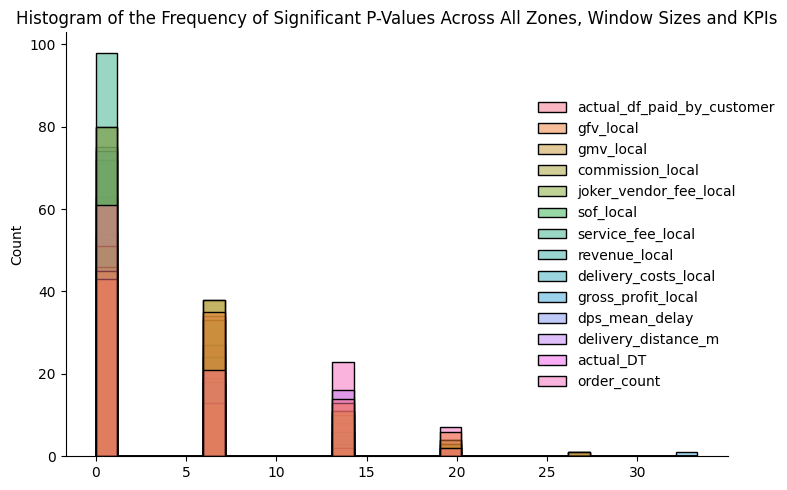

In [233]:
sns.displot(data = df_pval_sig_num)
plt.title('Histogram of the Frequency of Significant P-Values Across All Zones, Window Sizes and KPIs')
plt.tight_layout()